In [237]:
import os
import requests
import json
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import shapely
import geopandas as gpd

from pathlib import Path
from dotenv import load_dotenv
from os.path import join
from typing import List, Dict
from datetime import datetime, timezone


path = Path(__file__).resolve()
ROOT_PATH = path.parents[1]

# Basic paths to key folders
SRC_PATH = ROOT_PATH / 'src'
DATA_PATH = ROOT_PATH / 'data'
FIRTH_DATA_PATH = DATA_PATH / 'firth_clyde_fishing_effort'

load_dotenv(join(SRC_PATH, '.env'))

True

In [9]:
API_URL = 'https://gateway.api.globalfishingwatch.org/v2/4wings/report'
API_TOKEN =  os.getenv('GFW_TOKEN')
API_HEADERS = {
    'Authorization': f'Bearer {API_TOKEN}',
}

#'2021-01-01T00:00:00.000Z,2022-01-01T00:00:00.000Z'
API_PARAMS = {
    'spatial-resolution': 'low',
    'temporal-resolution': 'yearly',
    'group-by': 'gearType',
    'datasets[0]': 'public-global-fishing-effort:latest',
    'date-range': None,
    'format': 'json'
}
API_DATA = {'geojson': {
    'type': 'Polygon',
    'coordinates': [[
    [-5.6115,55.0049],# bottom-left; polygon formed counter-clock wise
    [-4.6104,55.0049],
    [-4.6104,56.0994],
    [-5.6115,56.0994],
    [-5.6115,55.0049],
    ]]
}}
REQUESTED_YEARS = [2012 + x for x in range(11)]

In [10]:
def build_data_range(years: List[int]) -> List[str]:
    data = []
    for year in years:
        start_date = datetime(year, 1, 1, 0, 0, 0, tzinfo=timezone.utc).isoformat().replace("+00:00", "Z")
        end_date = datetime(year + 1, 1, 1, 0, 0, 0, tzinfo=timezone.utc).isoformat().replace("+00:00", "Z")
        data.append(f"{start_date},{end_date}")
    return data

In [24]:
def build_multiple_request_parameters (api_url: str, 
                                       api_headers: Dict, 
                                       api_params: Dict, 
                                       api_data: Dict, 
                                       years: List[int]) -> List[Dict]:
    data = []
    date_range = build_data_range (years)
    for period in date_range:
        params = dict(api_params)
        params['date-range'] = period
        data.append({
            'url' : api_url,
            'headers': api_headers,
            'params': params,
            'json': api_data
        })
    return data
        

In [36]:
years = [2012 + x for x in range(11)]
api_context = build_multiple_request_parameters(API_URL, API_HEADERS, API_PARAMS, API_DATA, REQUESTED_YEARS)

In [28]:
# fishing_effort_data = []
# with requests.Session() as r_s:
#     for context in api_context:
#         r = r_s.post(**context)
#         fishing_effort_data.append(r.json())

In [31]:
def concatenate_time_series(api_results: List[Dict]) -> pd.DataFrame:
    return pd.concat([
        pd.DataFrame.from_records (record['entries'][0]['public-global-fishing-effort:v20201001']) 
        for record in api_results
    ])

In [32]:
timeseries = concatenate_time_series (fishing_effort_data)

In [92]:
# create dataset for a stacked barplot
stack_barplot_df = timeseries[['date', 'geartype', 'hours']]
stack_barplot_df = stack_barplot_df.groupby(['date', 'geartype']).agg({'hours': 'sum'}).reset_index()
stack_barplot_df = stack_barplot_df.sort_values(['date', 'hours'], ascending=[True, False])
stack_barplot_df

,date,geartype,hours
2,2012,trawlers,2214.153333
1,2012,set_gillnets,376.740278
0,2012,fishing,225.152500
6,2013,trawlers,21593.288889
4,2013,fishing,995.507500
...,...,...,...
63,2022,trawlers,51763.193229
61,2022,set_gillnets,2382.869728
60,2022,fishing,941.391189
59,2022,dredge_fishing,557.003556


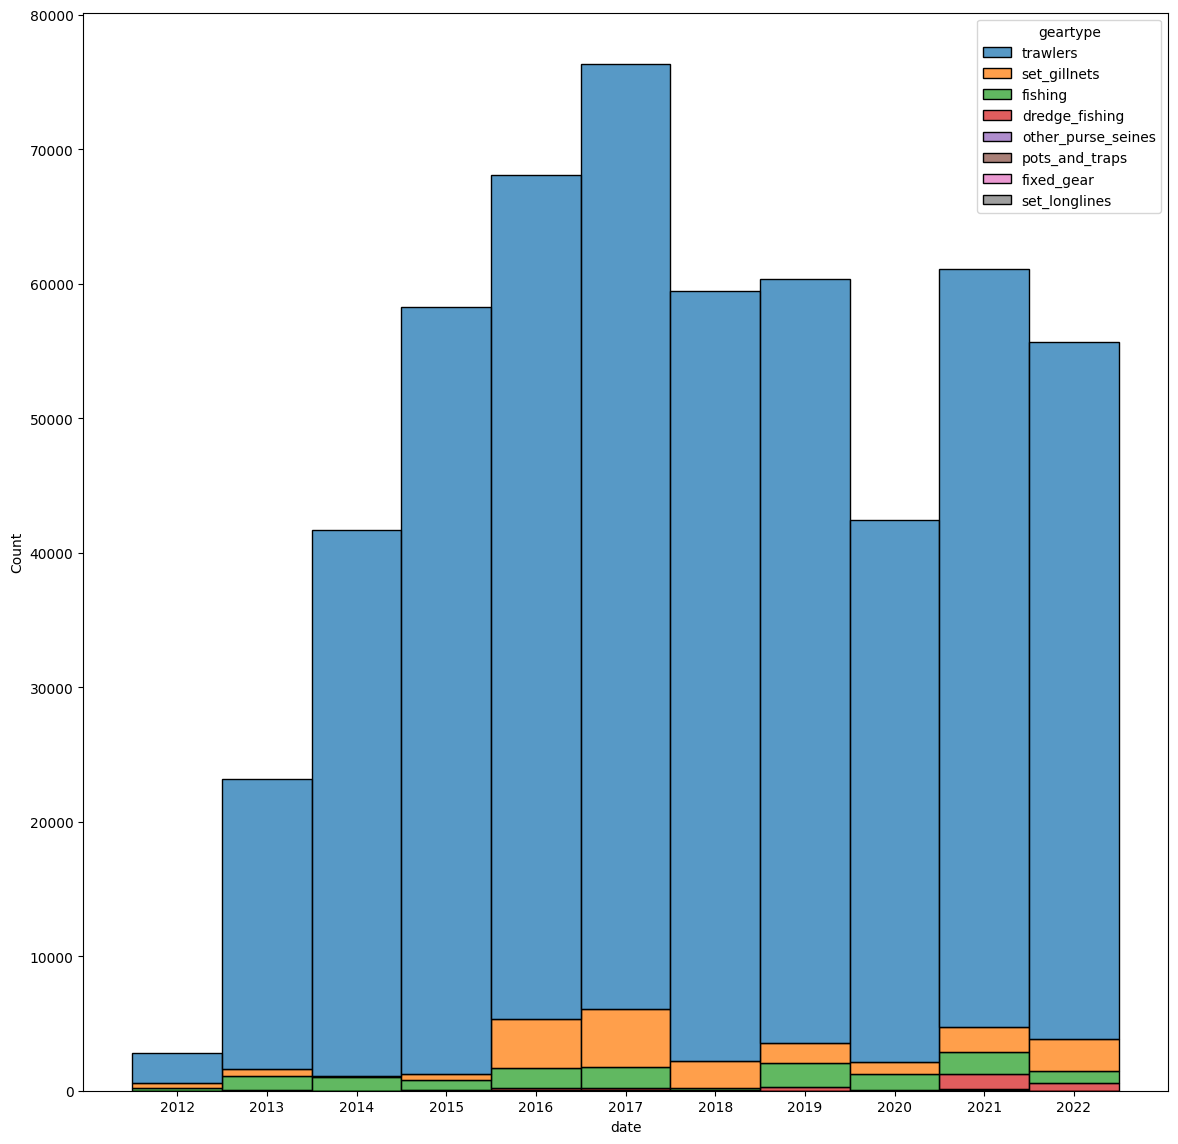

In [93]:
plt.figure(figsize=(14, 14))
ax = sns.histplot(stack_barplot_df, x='date', hue='geartype', weights='hours',
             multiple='stack')

In [199]:
scatter_line_plot_df = stack_barplot_df.copy()
scatter_line_plot_df.loc[scatter_line_plot_df["hours"] <= 0, "hours"] = 10 ** -10
scatter_line_plot_df = scatter_line_plot_df.assign (hours=np.log(scatter_line_plot_df["hours"]))
scatter_line_plot_df

,date,geartype,hours
2,2012,trawlers,7.702625
1,2012,set_gillnets,5.931556
0,2012,fishing,5.416778
6,2013,trawlers,9.980138
4,2013,fishing,6.903253
...,...,...,...
63,2022,trawlers,10.854435
61,2022,set_gillnets,7.776061
60,2022,fishing,6.847359
59,2022,dredge_fishing,6.322572


<AxesSubplot: xlabel='date', ylabel='hours'>

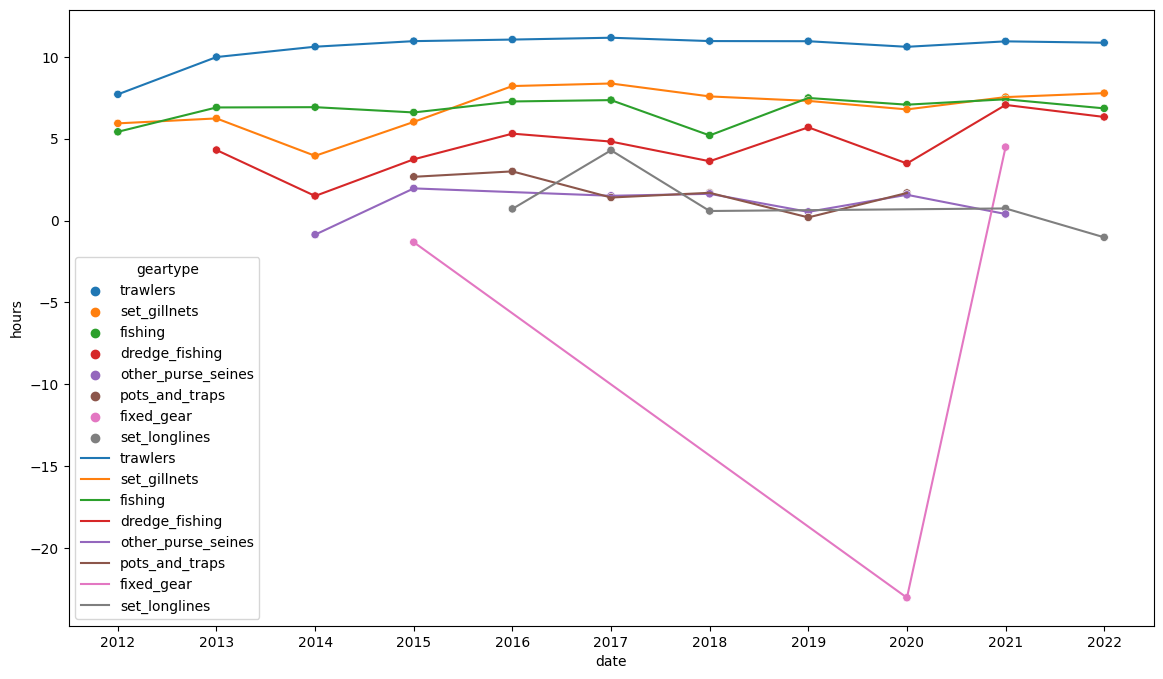

In [200]:
_, ax =plt.subplots(nrows=1, ncols=1, figsize=(14,8))
sns.scatterplot(data=scatter_line_plot_df, 
                x = "date", 
                y ="hours",
                hue='geartype', 
                ax = ax)
sns.lineplot(data=scatter_line_plot_df, 
                x = "date", 
                y="hours",
                hue='geartype', 
             ax = ax)

In [281]:
def create_fishing_effort_year
# Create vector of points
yearly_average_trawling = timeseries.loc [(timeseries['geartype'] == 'trawlers') & (timeseries['hours'] > 0)]
yearly_average_trawling = yearly_average_trawling[['lon', 'lat', 'hours']]
yearly_average_trawling = yearly_average_trawling.rename(columns={'lon': 'x', 'lat': 'y'})
yearly_average_trawling = yearly_average_trawling.groupby(['x', 'y']).agg({'hours': 'sum'}).reset_index()

assert round(yearly_average_trawling['hours'].sum()) == round(timeseries.loc[timeseries['geartype'] == 'trawlers', 'hours'].sum())

yearly_average_trawling.loc[:, 'percentage_hours'] = yearly_average_trawling['hours'] / yearly_average_trawling['hours'].sum()
yearly_average_trawling = yearly_average_trawling.round({'hours': 0})
yearly_average_trawling

,x,y,hours,percentage_hours
0,-5.6,55.0,175.0,0.000338
1,-5.6,55.1,105.0,0.000204
2,-5.6,55.2,12.0,0.000023
3,-5.6,55.3,31.0,0.000060
4,-5.6,55.4,69.0,0.000133
...,...,...,...,...
85,-4.8,56.0,1865.0,0.003609
86,-4.7,55.4,132.0,0.000255
87,-4.7,55.5,2207.0,0.004270
88,-4.7,55.6,864.0,0.001672


<AxesSubplot: >

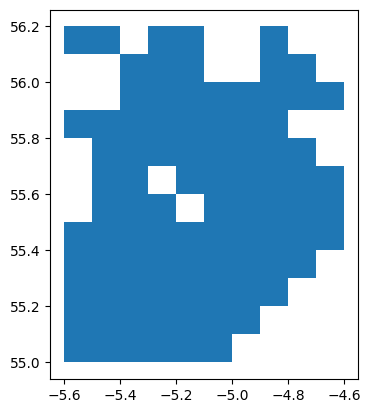

In [284]:
# Create vector of polygons out of those points
degree_offset = 0.1
geo_yearly_average_trawling = gpd.GeoDataFrame(yearly_average_trawling, geometry= gpd.points_from_xy(yearly_average_trawling.x, yearly_average_trawling.y))
geo_yearly_average_trawling['geometry'] = geo_yearly_average_trawling.apply(
    lambda s: shapely.geometry.Polygon(
        [
            [s['x'], s['y']],
            [s['x'] + degree_offset, s['y']],
            [s['x'] + degree_offset, s['y'] + degree_offset],
            [s['x'], s['y'] + degree_offset],
        ]),
    axis=1,
)

geo_yearly_average_trawling = geo_yearly_average_trawling.drop(columns=['x', 'y'])
geo_yearly_average_trawling.plot()


In [285]:
geo_yearly_average_trawling.to_csv(FIRTH_DATA_PATH / 'trawling_average_by_cell.csv', index=False)